In [7]:
import numpy as np

import lightgbm as lgb

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [8]:
dataset = datasets.fetch_covtype()

X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, random_state=179)

In [9]:
training_set = lgb.Dataset(X_train, y_train - 1)
test_set = lgb.Dataset(X_test, y_test - 1)

In [10]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_classes': '7',
    'metric': {'auc_mu'},
    'num_leaves': 120,
    'learning_rate': 0.09,
    'force_row_wise': True,
    'verbose': 0
}

In [11]:
def learning_rate_decay(initial_lr, decay_rate):
    def _decay(iteration):
        return initial_lr * (decay_rate ** iteration)
    return _decay

In [12]:
metrics = {}
callbacks = [
    lgb.log_evaluation(period=15),
    lgb.record_evaluation(metrics),
    lgb.early_stopping(15),
    lgb.reset_parameter(learning_rate=learning_rate_decay(0.09, 0.999))
]

In [13]:
%%time
gbm = lgb.train(params, training_set, num_boost_round=150, valid_sets=test_set, callbacks=callbacks)

Training until validation scores don't improve for 15 rounds
[15]	valid_0's auc_mu: 0.991161
[30]	valid_0's auc_mu: 0.994448
[45]	valid_0's auc_mu: 0.99573
[60]	valid_0's auc_mu: 0.996388
[75]	valid_0's auc_mu: 0.996781
[90]	valid_0's auc_mu: 0.997185
[105]	valid_0's auc_mu: 0.997565
[120]	valid_0's auc_mu: 0.997818
[135]	valid_0's auc_mu: 0.998015
[150]	valid_0's auc_mu: 0.994935
Did not meet early stopping. Best iteration is:
[141]	valid_0's auc_mu: 0.998084
CPU times: user 4min 54s, sys: 963 ms, total: 4min 54s
Wall time: 49.6 s


In [14]:
y_pred = np.argmax(gbm.predict(X_test, num_iteration=gbm.best_iteration), axis=1)
f1_score(y_test - 1, y_pred, average="macro")

0.9165993281538187

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc_mu'>

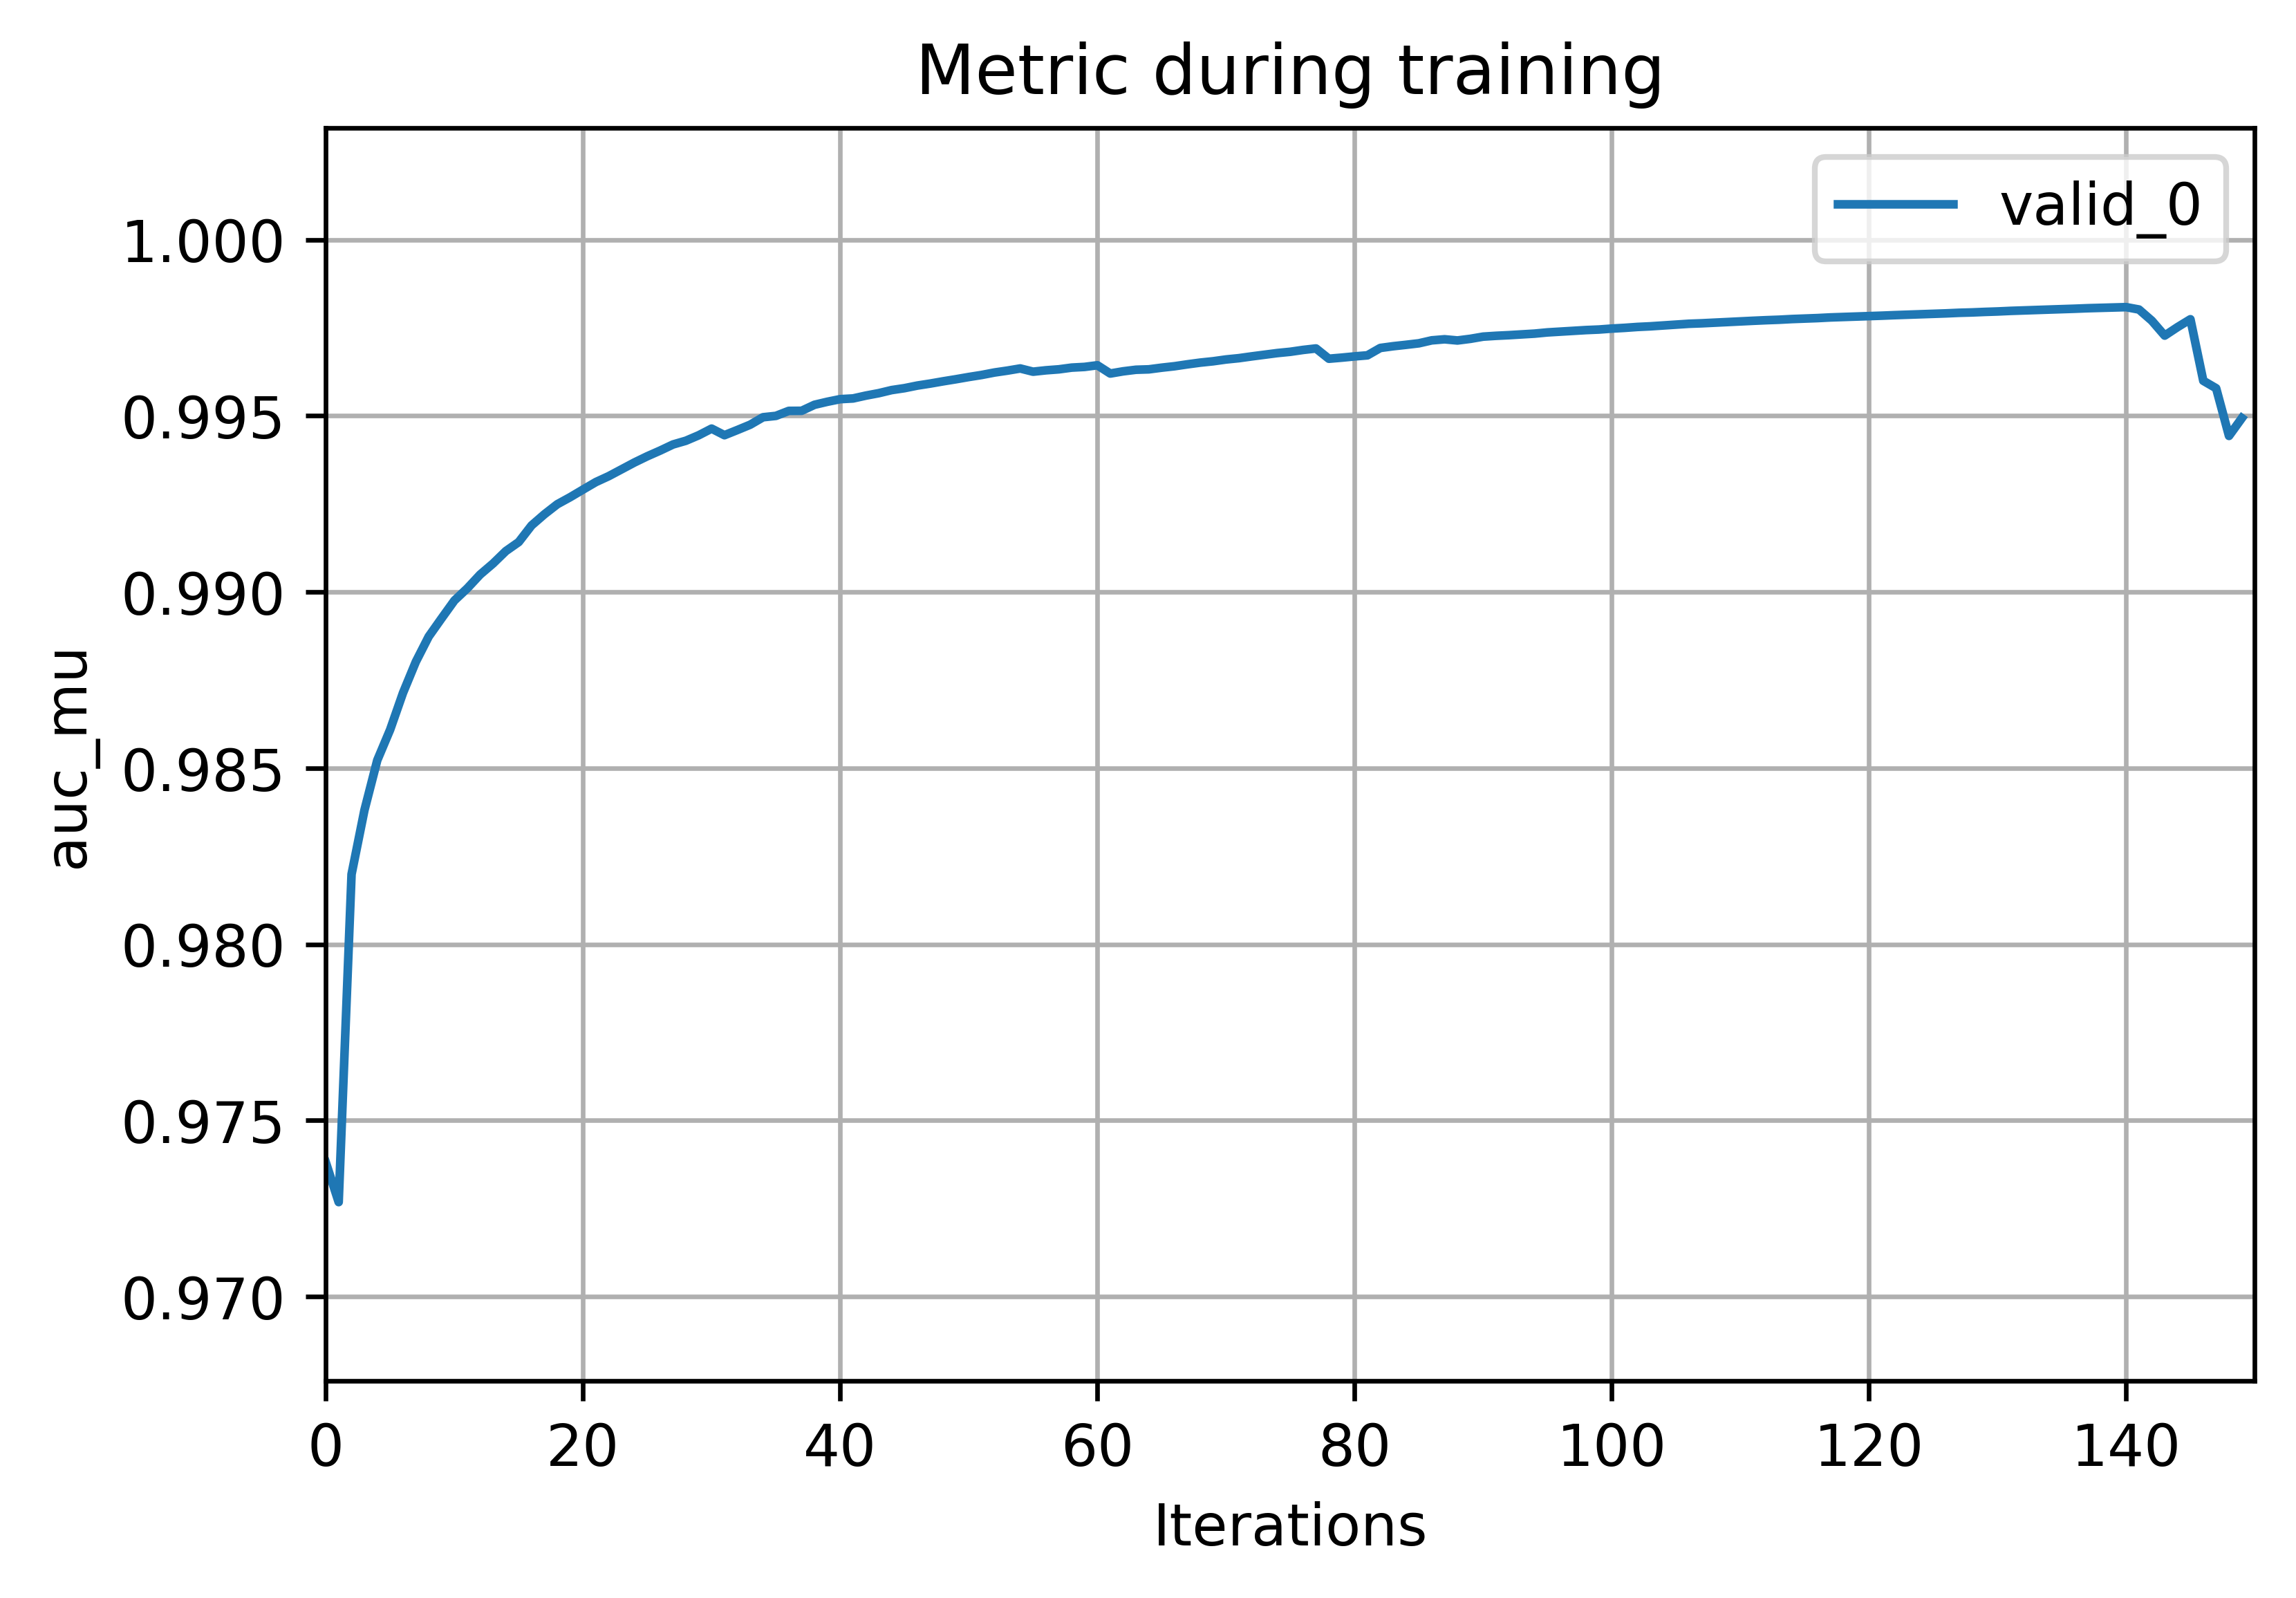

In [15]:
lgb.plot_metric(metrics, 'auc_mu')